## HF/LF analysis

See vsb_analyze-power-line-signals_parallel.py for HF/LF signal division

In [1]:
import csv
import numpy as np
from scipy.interpolate import interp1d
from scipy import fftpack, signal
from scipy.signal import butter, filtfilt, hilbert
from scipy.signal import sosfilt, sosfreqz
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq
import pickle
import re
import random

In [2]:
import datashader as ds
from datashader import transfer_functions as tf

In [3]:
period = 0.02
time_step = 0.02 / 800000.
time_vec = np.arange(0, 0.02, time_step)
f_sampling = 1 / time_step
print(f'Sampling Frequency = {f_sampling / 1e6} MHz')
# print (str(50* 800000 /1e6) + ' MHz')

Sampling Frequency = 40.0 MHz


Read signals (variable x). 
I would like to thank https://www.kaggle.com/xhlulu/exploring-signal-processing-with-scipy and the host: https://www.kaggle.com/sohier/reading-the-data-with-python

In [42]:
non_decimal = re.compile(r'[^\d-]+')
def data_as_float(data_list):
    data_flt=[]
    for i in data_list:
        j = non_decimal.sub('', i)
        data_flt.append(float(j))
    return data_flt

In [60]:
def create_sig_dict(sig_df, column_name, split_signal_name=True):
    sig_d={}
    data_counts={}
    for index, row in sig_df.iterrows():
        if split_signal_name:
            sig_id = row['signal_name'].split('_')[0]
        else:
            sig_id = row['signal_name']
        datas = row[column_name]
        datas = datas.split(",")
        data_flt = data_as_float(datas)
        sig_d[sig_id]=data_flt
    return sig_d

In [59]:
def create_sig_list(sig_df, column_name, split_signal_name=True):
    sig_list=[]
    data_counts={}
    for index, row in sig_df.iterrows():
        if split_signal_name:
            sig_id = row['signal_name'].split('_')[0]
        else:
            sig_id = row['signal_name']
        datas = row[column_name]
        datas = datas.split(",")
        data_counts[sig_id]=len(datas)
        sig_list.extend(datas)
    return sig_list, data_counts

### VLF

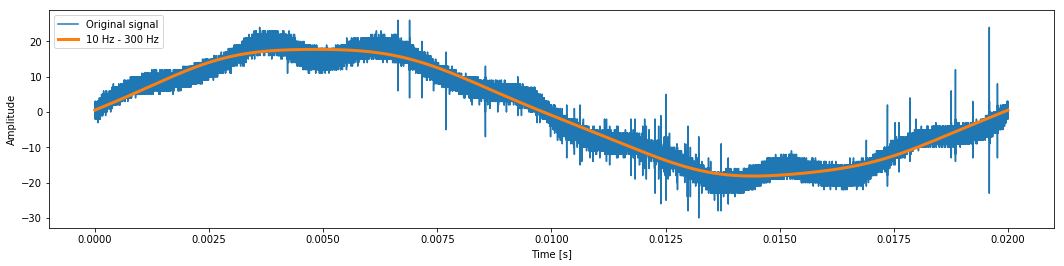

In [135]:
# We also demonstrate a band-pass filtered and a high-pass filtered signals. 
lowcut, highcut = 10, 300
filtered_sig4 = bandpassfilter(sig_fft, sample_freq, lowcut, highcut)
plt.figure(figsize=(18,4))
plt.plot(time_vec, sig, label='Original signal')
plt.plot(time_vec, filtered_sig4, linewidth=3, label='10 Hz - 300 Hz')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

In [ ]:
#see vsb_analyze-power-line-signals_parallel.py for batch processing of HF/LF signals

In [ ]:
sig0 = pq.read_table('../input/bp_signals/train_hf_sig_0.parquet').to_pandas()
print((sig0.shape))
sig0.head(2)

In [7]:
for i in range(10):
    print(f'loading train hf file {i}')
    if i==0:
        df_hf = pq.read_table(f'../input/bp_signals/train_hf_sig_{i}.parquet').to_pandas()
        df_hf=df_hf.T
    else:
        df = pq.read_table(f'../input/bp_signals/train_hf_sig_{i}.parquet').to_pandas()
        df=df.T
        df_hf = df_hf.append(df)

loading train hf file 0
loading train hf file 1
loading train hf file 2
loading train hf file 3
loading train hf file 4
loading train hf file 5
loading train hf file 6
loading train hf file 7
loading train hf file 8
loading train hf file 9


In [8]:
df_hf.shape

(8712, 800000)

In [9]:
for i in range(10):
    print(f'loading train lf file {i}')
    if i==0:
        df_lf = pq.read_table(f'../input/bp_signals/train_lf_sig_{i}.parquet').to_pandas()
        df_lf=df_lf.T
    else:
        df = pq.read_table(f'../input/bp_signals/train_lf_sig_{i}.parquet').to_pandas()
        df=df.T
        df_lf = df_lf.append(df)

loading train lf file 0
loading train lf file 1
loading train lf file 2
loading train lf file 3
loading train lf file 4
loading train lf file 5
loading train lf file 6
loading train lf file 7
loading train lf file 8
loading train lf file 9


In [10]:
df_lf.shape

(8712, 800000)

In [12]:
df_hf=df_hf.T

In [13]:
type(list(df_hf.columns.values)[0])

str

In [15]:
#OK we can save as parguet (needs str headers)
df_hf.to_parquet(f'../input/bp_signals/train_hf_sig.parquet')

In [16]:
df_lf=df_lf.T

In [17]:
df_lf.to_parquet(f'../input/bp_signals/train_lf_sig.parquet')

#### Read HF/LF components

In [4]:
data_bp = '../data/ML_Data/kaggle/VSB_Power_Line_Fault_Detection/bp_signals/'
df_hf = pq.read_table(data_bp+'train_hf_sig.parquet').to_pandas()

In [5]:
df_lf = pq.read_table(data_bp+'train_lf_sig.parquet').to_pandas()

OSError: Passed non-file path: ../data/ML_Data/kaggle/VSB_Power_Line_Fault_Detection/bp_signals/train_lf_sig.parquet

## VLF

In [4]:
data_bp = '../data/ML_Data/kaggle/VSB_Power_Line_Fault_Detection/bp_signals/'
for i in range(10):
    print(f'loading train vlf lf file {i}')
    if i==0:
        df_vlf_lf = pq.read_table(data_bp+f'train_vlf_lf_sig_{i}.parquet').to_pandas()
        df_vlf_lf=df_vlf_lf.T
    else:
        df = pq.read_table(data_bp+f'train_vlf_lf_sig_{i}.parquet').to_pandas()
        df=df.T
        df_vlf_lf = df_vlf_lf.append(df)

loading train vlf lf file 0
loading train vlf lf file 1
loading train vlf lf file 2
loading train vlf lf file 3
loading train vlf lf file 4
loading train vlf lf file 5
loading train vlf lf file 6
loading train vlf lf file 7
loading train vlf lf file 8
loading train vlf lf file 9


In [5]:
df_vlf_lf=df_vlf_lf.T

In [6]:
df_vlf_lf.to_parquet(f'../input/bp_signals/train_vlf_lf_sig.parquet')

### test data

In [ ]:
for i in range(10):
    print(f'loading test file {i}')
    if i==0:
        df_hf = pq.read_table(f'../data/ML_Data/kaggle/VSB_Power_Line_Fault_Detection/bp_signals/test_sig_{i}.parquet').to_pandas()
        df_hf=df_hf.T
    else:
        df = pq.read_table(f'../data/ML_Data/kaggle/VSB_Power_Line_Fault_Detection/bp_signals/test_sig_{i}.parquet').to_pandas()
        df=df.T
        df_hf = df_hf.append(df)

In [ ]:
df_hf=df_hf.T

In [ ]:
#OK we can save as parguet (needs str headers)
df_hf.to_parquet(f'../data/bp_signals/test_hf_sig.parquet')

### Re-load

In [ ]:
df_lf = pq.read_table(f'../input/bp_signals/train_lf_sig.parquet').to_pandas()

In [ ]:
df_lf.shape


In [ ]:
df_lf.head(2)

In [ ]:
len(df_lf)

In [119]:
# Fetch one signal from xs
idx = 1
sig = df_lf.iloc[:, idx]
idx_error = 3
sig_error = df_lf.iloc[:, idx_error]
print(sig.shape)

(800000,)


In [120]:
sig_fft = fftpack.fft(sig)

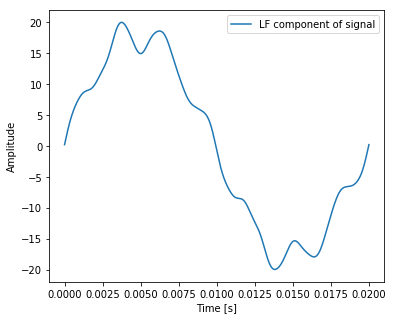

In [121]:
plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig, label='LF component of signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

### HF components

In [ ]:
bad_hf = pq.read_table(f'../input/bp_signals/bad_hf_sig.parquet').to_pandas()

In [ ]:
bad_hf.head(n=2)

In [7]:
# Fetch one hf signal
idx = 1
sig_hf = bad_hf.iloc[:, idx]
idx_error = 3
sig_hf_error = bad_hf.iloc[:, idx_error]
print(sig_hf.shape)

(800000,)


In [8]:
sig_hf = bad_hf['3']

In [124]:
sig_lf = df_lf['3']

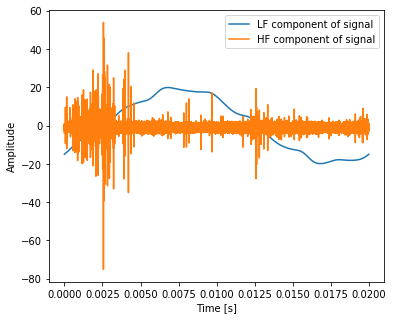

In [125]:
plt.figure(figsize=(6, 5))
plt.plot(time_vec, sig_lf, label='LF component of signal')
plt.plot(time_vec, sig_hf, label='HF component of signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

#### good hf

In [23]:
good_hf = pq.read_table(f'../input/bp_signals/good_hf_sig.parquet').to_pandas()

In [24]:
good_hf.head(n=2)

,0,1,2,6,7,8,9,10,11,12,...,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,-1.048705,0.786055,0.179286,-0.417712,-2.361912,0.079016,-2.470254,1.350346,-0.151676,-1.145585,...,-0.000443,-2.190860,-2.162223,0.574183,-0.583502,-0.670861,-2.003877,-1.862254,-1.132162,-1.795980
1,-1.048605,-0.214229,0.179465,-2.417578,-1.361792,1.078762,-1.470414,0.350526,-1.151698,-0.145870,...,-1.000363,-1.190839,-2.162138,0.574084,0.416480,0.329202,-0.003919,-1.862355,-0.131924,-0.796107


### hilbert transform

In [12]:
def FilteredSignal(signal, fs, cutoff):
    B, A = butter(1, cutoff / (fs / 2), btype='low')
    filtered_signal = filtfilt(B, A, signal, axis=0)
    return filtered_signal

In [29]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        w, h = sosfreqz(sos, worN=2000)
        return y, w, h

(-40, 40)

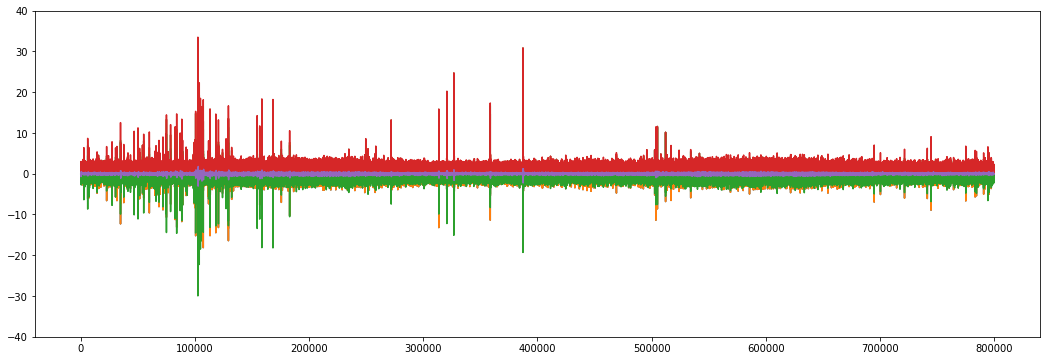

In [34]:
plt.figure(figsize=(18, 6))
plt.plot(sig_hf)

analytical_signal = hilbert(sig_hf)
plt.plot(analytical_signal.real)
plt.plot(analytical_signal.imag)


amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope)

# Sample rate and desired cutoff frequencies (in Hz).
fs = 800000.0
lowcut = 1000.0
highcut = 5000.0
y, w, h = butter_bandpass_filter(amplitude_envelope, lowcut, highcut, fs, order=5)
plt.plot(y)
#plt.plot(w)
#plt.plot(h.real)
plt.ylim(-40,40)




In [94]:
def calc_envelope(x, ind):
    x_abs = np.abs(x)
    print(x_abs.shape)
    
    loc = np.where(np.diff(np.sign(np.diff(x_abs))) < 0)[0] + 1
    print(f'loc.shape: {loc.shape}')
    peak = x_abs[loc]
    print(f'peak.shape: {peak.shape}')
    envelope = np.interp(ind, loc, peak)
    return envelope

(800000,)
loc.shape: (167346,)
peak.shape: (167346,)


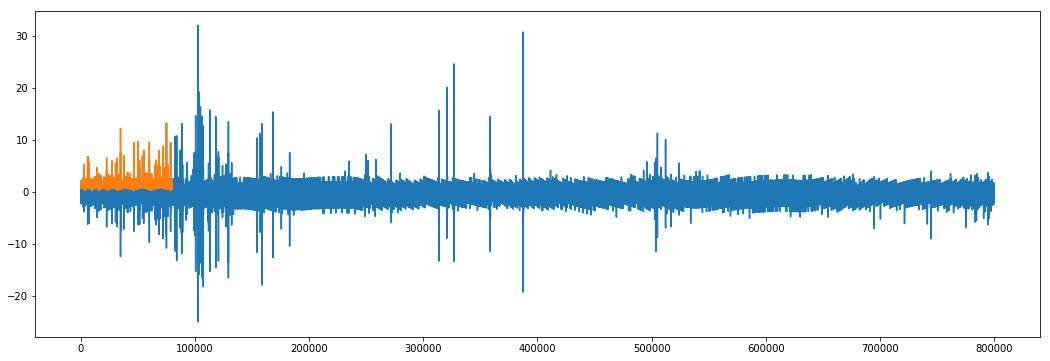

In [95]:
plt.figure(figsize=(18, 6))
plt.plot(sig_hf)
env = calc_envelope(sig_hf, range(80000))
plt.plot(env)



    The code below does not filter peaks or troughs that may be occuring closer than some threshold "distance" (Tl) (e.g. time). This is similar to the second parameter of envelope. It is easy to add it though by examining the differences between consecutive values of u_x,u_y.

    However, a quick improvement over the point mentioned previously is to lowpass filter your data with a moving average filter BEFORE interpolating an upper and lower envelope functions. You can do this easily by convolving your (s) with a suitable moving average filter. Without going to a great detail here (can do if required), to produce a moving average filter that operates over N consecutive samples, you would do something like this: s_filtered = numpy.convolve(s, numpy.ones((1,N))/float(N). The higher the (N) the smoother your data will appear. Please note however that this will shift your (s) values (N/2) samples to the right (in s_filtered) due to something that is called group delay of the smoothing filter. For more information about the moving average, please see this link.


In [96]:
def high_low_interpol(s):
    print(s.shape)
    print(s[0])
    print(s[-1])
    q_u = zeros(s.shape)
    q_l = zeros(s.shape)

    #Prepend the first value of (s) to the interpolating values. This forces the model to use the same starting point for both the upper and lower envelope models.
    u_x = [0,]
    u_y = [s[0],]

    l_x = [0,]
    l_y = [s[0],]

    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.
    for k in range(1,len(s)-1):
        if (sign(s[k]-s[k-1])==1) and (sign(s[k]-s[k+1])==1):
            u_x.append(k)
            u_y.append(s[k])

        if (sign(s[k]-s[k-1])==-1) and ((sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])

    #Append the last value of (s) to the interpolating values. This forces the model to use the same ending point for both the upper and lower envelope models.
    u_x.append(len(s)-1)
    u_y.append(s[-1])

    l_x.append(len(s)-1)
    l_y.append(s[-1])

    #Fit suitable models to the data. Here I am using cubic splines, similarly to the MATLAB example given in the question.
    u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
    l_p = interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)

    #Evaluate each model over the domain of (s)
    for k in range(0,len(s)):
        q_u[k] = u_p(k)
        q_l[k] = l_p(k)

    #Plot everything
    plt.plot(s)
    plt.plot(q_u,'r')
    plt.plot(q_l,'g')

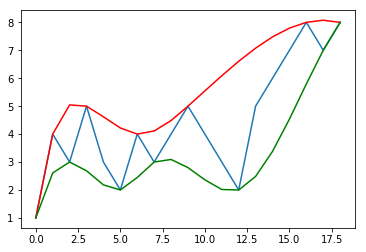

In [60]:
s = array([1,4,3,5,3,2,4,3,4,5,4,3,2,5,6,7,8,7,8]) #This is your noisy vector of values.
high_low_interpol(s)


In [68]:
sig_mva = sig_hf.rolling(10).mean()

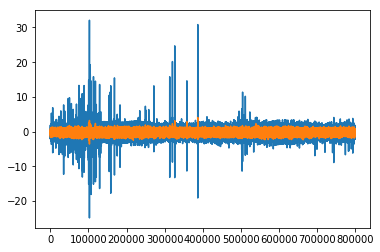

In [70]:
plt.plot(sig_hf)
plt.plot(sig_mva)

(1000,)


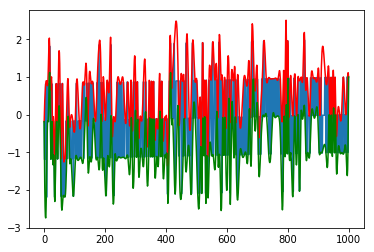

In [72]:
high_low_interpol(sig_hf[:1000].values)

In [87]:
max_1k = sig_hf.rolling(8000).max().dropna()

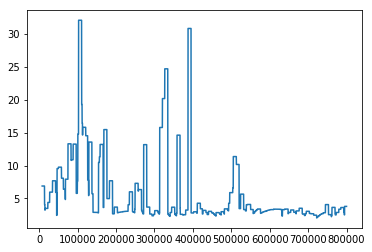

In [88]:
plt.plot(max_1k)

In [86]:
max_1k.shape, sig_hf.shape

((720001,), (800000,))

In [101]:
len(max_1k[::1000])

793

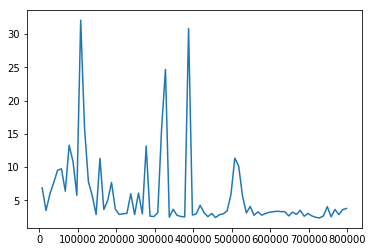

In [106]:
b = max_1k[::10000].copy()
plt.plot(b)

(80,)
6.8803992055695105
3.783500903493953


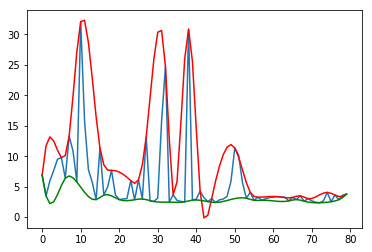

In [108]:
high_low_interpol(b.values)

In [10]:
sig_hf_t = sig_hf.copy()
thresh=4.0
super_threshold_indices = sig_hf_t < thresh
sig_hf_t[super_threshold_indices] = 0

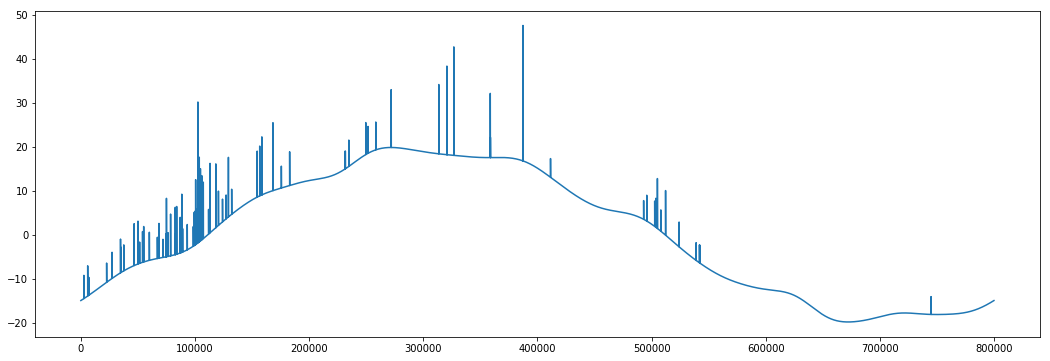

In [126]:
plt.figure(figsize=(18, 6))
plt.plot(sig_hf_t+sig_lf)


### VLF

Load the VLF signal

In [ ]:
df_vlf_lf = pq.read_table(f'../input/bp_signals/train_vlf_lf_sig.parquet').to_pandas()

In [ ]:
#index of the maximum voltage
idx = 1
sig_vlf = df_vlf_lf.iloc[:, idx]
max_idx = sig_vlf.argmax()
min_idx = sig_vlf.argmin()

In [ ]:
#get the distance of the spurious voltage peaks from the maximum and minimum indices 

In [11]:
len(sig_hf_t)

800000

### Signal Analysis

In [ ]:
#for each signal get distances


In [161]:
#note our default voltage threshhold below is 4.0 volts
def get_sig_relatives(hf_df, lf_df, thresh=4.0):
    #eg hf_df = bad_hf; lf_df=df_vlf_lf
    cols = list(hf_df)
    sig_neg_deltas = {}
    sig_deltas= {}
    sig_ampls = {}
    sig_idxs = {}
    lf_min = {}
    lf_max = {}
    for sig_id in cols:
        sig_vlf = lf_df[sig_id]
        max_idx = sig_vlf.argmax()
        min_idx = sig_vlf.argmin()

        delta_vals = []
        delta_neg_vals = []
        val_idxs=[]
        sig_amp=[]
        sig_hf = hf_df[sig_id]
        sig_hf_t = sig_hf.copy()
        super_threshold_indices = sig_hf_t < thresh
        sig_hf_t[super_threshold_indices] = 0
        for i, v in sig_hf_t.iteritems():
            if v>0:
                delta_vals.append(i-max_idx)
                delta_neg_vals.append(i-min_idx)
                val_idxs.append(i)
                sig_amp.append(v)
        sig_neg_deltas[str(sig_id)] = delta_neg_vals
        sig_deltas[str(sig_id)] = delta_vals
        sig_idxs[str(sig_id)] = val_idxs
        sig_ampls[str(sig_id)] = sig_amp
        lf_min[str(sig_id)] = min_idx
        lf_max[str(sig_id)] = max_idx
    return sig_neg_deltas, sig_deltas, sig_idxs, sig_ampls, lf_min, lf_max

In [162]:
sig_neg_deltas, sig_deltas, sig_idxs, sig_ampls, lf_min, lf_max = get_sig_relatives(good_hf, lf_df=df_vlf_lf, thresh=4.0)


/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  if sys.path[0] == '':
/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  del sys.path[0]


#### these then move to signal analysis folder

In [163]:
with open(f'../input/signal_analysis/good_signals/sig_neg_deltas.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_neg_deltas.items())

In [27]:
with open(f'../input/signal_analysis/good_signals/sig_idxs.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_idxs.items())

In [28]:
with open(f'../input/signal_analysis/good_signals/sig_ampls.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_ampls.items())

In [29]:
with open(f'../input/signal_analysis/good_signals/sig_deltas.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_deltas.items())

In [164]:
with open(f'../input/signal_analysis/good_signals/lf_min.csv','w') as f:
    w = csv.writer(f)
    w.writerows(lf_min.items())

In [165]:
with open(f'../input/signal_analysis/good_signals/lf_max.csv','w') as f:
    w = csv.writer(f)
    w.writerows(lf_max.items())

#### bad

In [166]:
sig_neg_deltas, sig_deltas, sig_idxs, sig_ampls, lf_min, lf_max = get_sig_relatives(bad_hf, lf_df=df_vlf_lf, thresh=4.0)

/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  if sys.path[0] == '':
/home/walle/miniconda3/envs/fastai-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  del sys.path[0]


In [167]:
with open(f'../input/signal_analysis/bad_signals/sig_neg_deltas.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_neg_deltas.items())

In [ ]:
with open(f'../input/signal_analysis/bad_signals/sig_idxs.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_idxs.items())

In [ ]:
with open(f'../input/signal_analysis/bad_signals/sig_ampls.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_ampls.items())

In [ ]:
with open(f'../input/signal_analysis/bad_signals/sig_deltas.csv','w') as f:
    w = csv.writer(f)
    w.writerows(sig_deltas.items())

In [168]:
with open(f'../input/signal_analysis/bad_signals/lf_min.csv','w') as f:
    w = csv.writer(f)
    w.writerows(lf_min.items())

In [169]:
with open(f'../input/signal_analysis/bad_signals/lf_max.csv','w') as f:
    w = csv.writer(f)
    w.writerows(lf_max.items())

In [205]:
list(lf_min.keys())[0], list(lf_min.values())[0]

('3', 714929)

In [207]:
bad_lf_max_keys=list(lf_max.keys())
bad_lf_max_vals=list(lf_max.values())
bad_lf_max_keys=np.asarray(bad_lf_max_keys)
bad_lf_max_vals=np.asarray(bad_lf_max_vals)

In [208]:
peak_idx = (bad_lf_max_vals>100000)*(bad_lf_max_vals<300000)

In [209]:
peak_keys=bad_lf_max_keys[peak_idx]

In [210]:
len(peak_keys), peak_keys[0]

(125, '229')

#### plots

In [36]:
deltas_val_list=[]
for k,v in sig_deltas.items():
    deltas_val_list.extend(v)

(array([   9156.,   28687.,   56735.,  136432.,  137958.,  115571.,
         128463.,  142596.,  141523.,  170415.,  196095.,  481504.,
         852800.,  337757.,  277917.,  249845.,  259719.,  269076.,
         323288.,  425625., 1563174.,  884356.,  452438.,  424137.,
         423847.,  462605.,  462470.,  561868., 1050336., 1150109.,
         661906.,  588683.,  551856.,  568762.,  590937.,  674629.,
        1331811., 2293129.,  975461.,  734842.,  711781.,  678922.,
         726181.,  767974., 1133700., 3526392., 1959887., 1002306.,
         874504.,  873050.,  831616.,  953884., 1041087., 1997173.,
        1516281.,  951352.,  822866.,  757975.,  719020.,  737589.,
         768159., 1513754., 2663096., 1018831.,  728260.,  613988.,
         608173.,  562794.,  588605.,  728584., 2279653., 1293253.,
         559231.,  491442.,  443082.,  460900.,  442560.,  489104.,
         774532.,  823518.,  466867.,  372346.,  331684.,  299963.,
         278601.,  288678.,  476314.,  772545., 

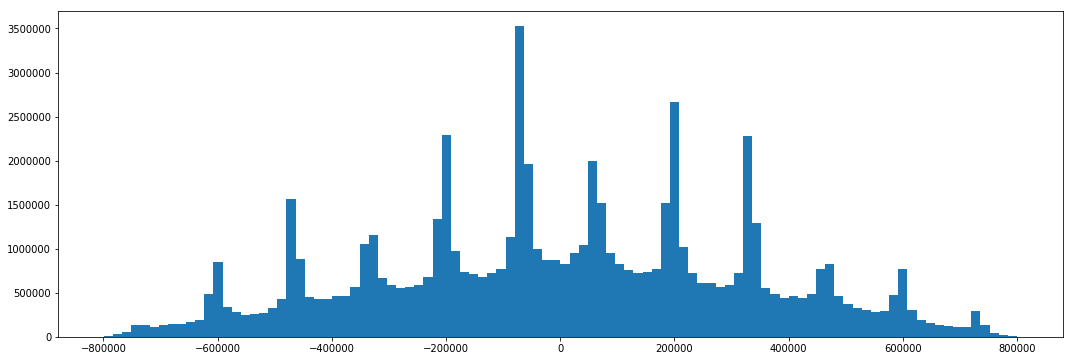

In [37]:
plt.figure(figsize=(18, 6))
plt.hist(deltas_val_list, bins=100)

clearly a relationship between voltage spike location wrt phase of the signal - for 'good' signals

In [38]:
ampl_val_list=[]
for k,v in sig_ampls.items():
    ampl_val_list.extend(v)

(array([4.3161004e+07, 1.3181022e+07, 4.8365110e+06, 1.9426310e+06,
        8.7120800e+05, 4.8020300e+05, 3.1931800e+05, 2.3663500e+05,
        1.8485000e+05, 1.4972400e+05, 1.2224600e+05, 1.0362400e+05,
        8.7765000e+04, 7.5902000e+04, 6.5454000e+04, 5.7187000e+04,
        5.0440000e+04, 4.4547000e+04, 4.0000000e+04, 3.5646000e+04,
        3.2195000e+04, 2.9302000e+04, 2.6423000e+04, 2.4158000e+04,
        2.2127000e+04, 2.0140000e+04, 1.8363000e+04, 1.6946000e+04,
        1.5330000e+04, 1.4438000e+04, 1.3210000e+04, 1.2095000e+04,
        1.1298000e+04, 1.0659000e+04, 9.8630000e+03, 9.1560000e+03,
        8.4550000e+03, 7.8400000e+03, 7.4220000e+03, 6.9360000e+03,
        6.5370000e+03, 6.1860000e+03, 5.5210000e+03, 5.2780000e+03,
        4.9960000e+03, 4.6870000e+03, 4.3540000e+03, 4.1070000e+03,
        3.8860000e+03, 3.6350000e+03, 3.5630000e+03, 3.2950000e+03,
        3.1520000e+03, 2.9040000e+03, 2.8710000e+03, 2.7690000e+03,
        2.6280000e+03, 2.4470000e+03, 2.3570000e

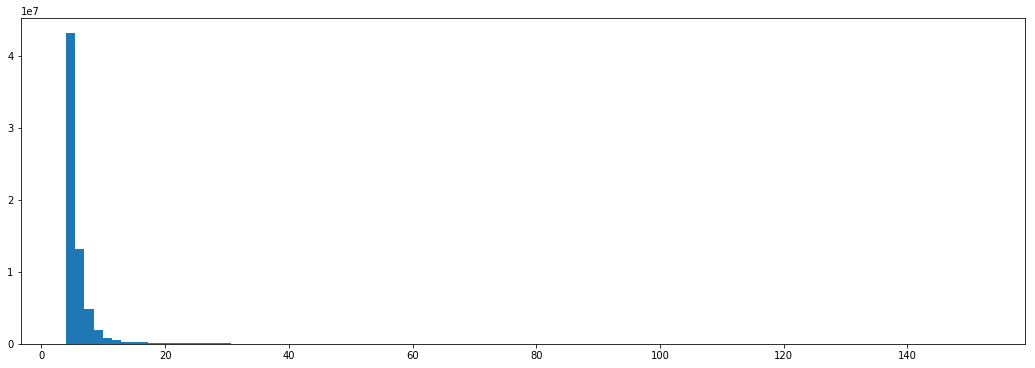

In [39]:
plt.figure(figsize=(18, 6))
plt.hist(ampl_val_list, bins=100)

#### Read in Signal analyses

#### bad

In [ ]:
bad_sig_ampls = pd.read_csv(f'../input/signal_analysis/bad_signals/sig_ampls.csv', names=['signal_name', 'ampl'])

In [44]:
bad_sig_ampls.head()

,signal_name,ampl
0,3_ampl,"[9.559935699543924, 14.97276466793794, 5.97222..."
1,4_ampl,"[5.294047279795442, 6.8803992055695105, 4.0530..."
2,5_ampl,"[8.180374296293564, 6.180351195971564, 4.18031..."
3,201_ampl,"[10.837130386283427, 4.837082464784626, 6.8369..."
4,202_ampl,"[4.612326267880844, 5.612922104952009, 5.63079..."


In [77]:

bad_sig_ampl_list=[]
for index, row in bad_sig_ampls.iterrows():
    ampls = row['ampl']
    ampls = ampls.split(",")
    bad_sig_ampl_list.extend(ampls)

In [78]:
len(bad_sig_ampl_list)

5513107

In [79]:
bad_sig_ampl_list[34]

' 18.666094496102826'

In [80]:
non_decimal = re.compile(r'[^\d.]+')
bad_sig_ampl_flt=[]
for i in bad_sig_ampl_list:
    j = non_decimal.sub('', i)
    bad_sig_ampl_flt.append(float(j))

In [81]:
bad_sig_ampl_flt[0], len(bad_sig_ampl_flt)


(9.559935699543924, 5513107)

In [ ]:
#filter out values to make smaller for plotting

In [88]:
n_up_ampl=[a for a in bad_sig_ampl_flt if (a >= 12)]

In [89]:
len(n_up_ampl)

513109

(array([1.01701e+05, 7.23770e+04, 5.38140e+04, 4.08390e+04, 3.25820e+04,
        2.67470e+04, 2.13730e+04, 1.85060e+04, 1.53570e+04, 1.30790e+04,
        1.12610e+04, 9.71400e+03, 8.53500e+03, 7.55700e+03, 6.67600e+03,
        5.90700e+03, 5.12000e+03, 4.76700e+03, 4.20000e+03, 3.73500e+03,
        3.34500e+03, 3.05500e+03, 2.71900e+03, 2.49600e+03, 2.30500e+03,
        2.15900e+03, 1.93400e+03, 1.77400e+03, 1.71100e+03, 1.50100e+03,
        1.42800e+03, 1.29000e+03, 1.22000e+03, 1.09100e+03, 1.03700e+03,
        9.62000e+02, 8.88000e+02, 8.10000e+02, 7.11000e+02, 7.35000e+02,
        6.70000e+02, 6.10000e+02, 5.79000e+02, 5.45000e+02, 5.27000e+02,
        5.13000e+02, 4.69000e+02, 4.65000e+02, 3.97000e+02, 3.81000e+02,
        3.84000e+02, 3.69000e+02, 3.42000e+02, 3.45000e+02, 3.27000e+02,
        2.96000e+02, 2.87000e+02, 2.83000e+02, 2.58000e+02, 3.60000e+02,
        3.77000e+02, 5.18000e+02, 4.94000e+02, 4.57000e+02, 3.97000e+02,
        4.16000e+02, 3.07000e+02, 2.82000e+02, 3.22

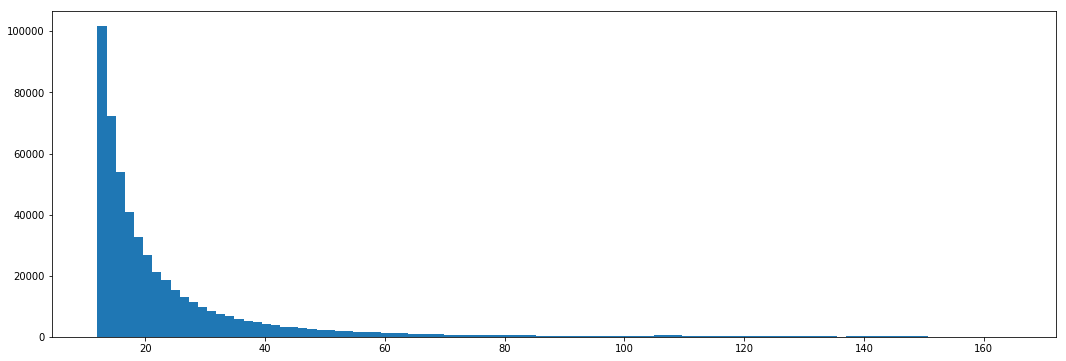

In [90]:
plt.figure(figsize=(18, 6))
plt.hist(n_up_ampl, bins=100)

#### Deltas

In [ ]:
bad_sig_deltas = pd.read_csv(f'../input/signal_analysis/bad_signals/sig_deltas.csv', names=['signal_name', 'delta'])

In [95]:
bad_sig_deltas.head()

,signal_name,delta
0,3_delta,"[-305035, -301673, -301670, -300653, -300650, ..."
1,4_delta,"[-569403, -566041, -565020, -549453, -544708, ..."
2,5_delta,"[-39162, -39160, -39157, -35800, -35798, -3579..."
3,201_delta,"[-441225, -441223, -441216, -441214, -441100, ..."
4,202_delta,"[-706095, -706091, -705971, -705961, -696129, ..."


In [177]:
bad_sig_delta_list=[]
spike_counts={}
for index, row in bad_sig_deltas.iterrows():
    sig_id = row['signal_name'].split('_')[0]
    deltas = row['delta']
    deltas = deltas.split(",")
    spike_counts[sig_id]=len(deltas)
    bad_sig_delta_list.extend(deltas)

In [178]:
spikes=list(spike_counts.values())

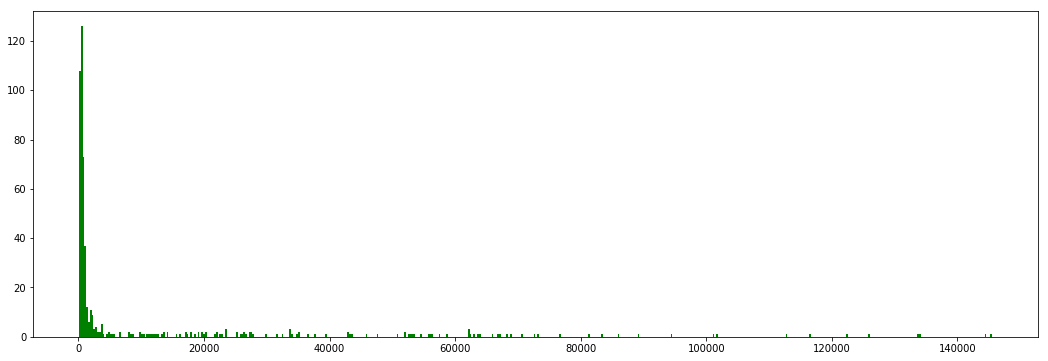

mu: 0.0019960079840319364, sigma: 0.015762952764644823


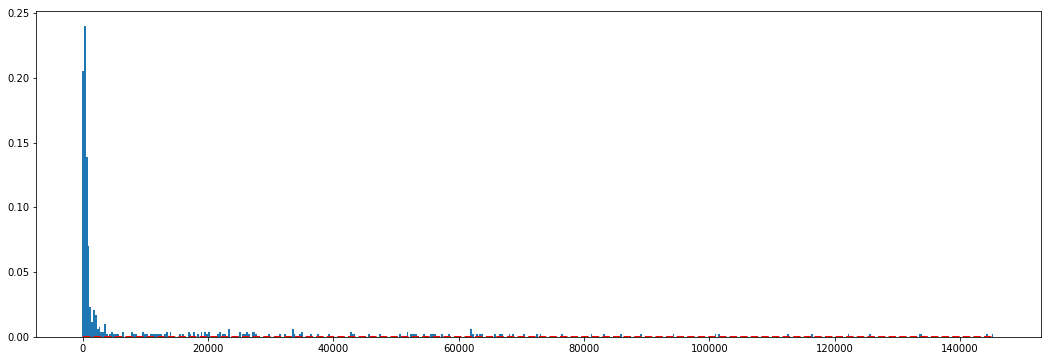

In [185]:
plt.figure(figsize=(18, 6))
spike_n, spike_bins, spike_patches = plt.hist(spikes, 500, histtype='bar', color='green')
plt.show()
spike_n = spike_n/len(spikes)
spike_n = np.append(spike_n, 0)
mu = np.mean(spike_n)
sigma = np.std(spike_n)
print(f'mu: {mu}, sigma: {sigma}')
plt.figure(figsize=(18, 6))
plt.bar(spike_bins, spike_n, width=(spike_bins[len(spike_bins)-1]-spike_bins[0])/500)
plt.show()

In [189]:
### just <10000
low_spikes = [x for x in spikes if x < 10000]

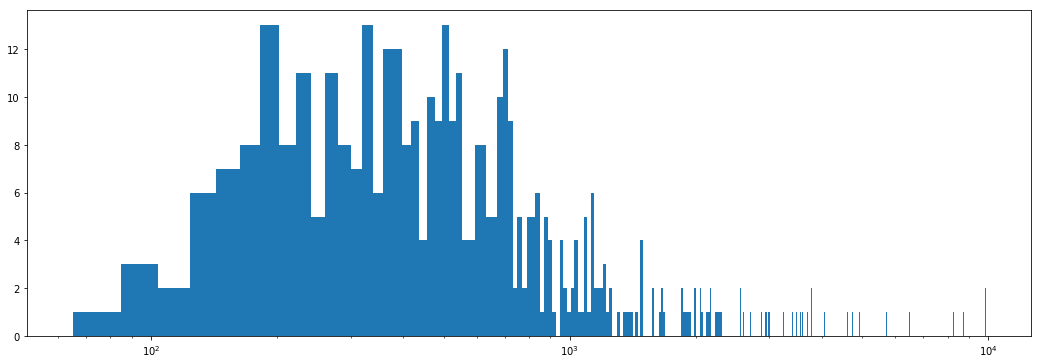

In [192]:
plt.figure(figsize=(18, 6))
plt.hist(low_spikes, bins=500)
plt.xscale('log')

In [ ]:
#sort of normally distributed (but with a very long tail) in log space ~ lognormal distribution

#### get signals with peak between 100k and 300k

In [212]:
peak_keys=peak_keys.tolist()
type(peak_keys[0])

str

In [219]:
bad_hf.head(n=2)

,3,4,5,201,202,228,229,230,270,271,...,8433,8434,8435,8481,8482,8483,8568,8569,8570,8630
0,-1.001802,-0.186245,-0.775627,-1.136759,0.450501,-3.810718,-4.127692,-0.572603,-0.561394,-0.856216,...,-1.014264,-0.049777,0.240119,-1.461975,-1.332391,-0.327350,-0.359743,-0.099931,0.063646,0.780848
1,-2.001965,-1.186059,-0.775649,-2.136783,-0.549349,-3.810633,-4.127786,-1.572598,1.438539,1.143811,...,-1.014227,-0.049841,0.240135,-1.461727,-0.332496,-0.327475,-1.359646,-0.099886,-0.936499,-3.219084


In [233]:
peak_bad_df = bad_hf[peak_keys]


In [234]:
peak_bad_df.head(n=2)

,229,270,279,287,410,433,436,458,518,571,...,7924,7948,8019,8032,8062,8281,8290,8434,8483,8570
0,-4.127692,-0.561394,-1.459120,-0.667467,-0.669975,0.937128,0.178128,-2.620207,-2.387275,-0.376683,...,0.355982,0.247090,-1.284089,0.670138,-1.217551,-1.996807,-2.492410,-0.049777,-0.327350,0.063646
1,-4.127786,1.438539,-1.459195,-0.667555,0.329949,-1.062893,-0.822080,1.379700,-0.387466,2.623257,...,1.355699,-0.752954,-1.284153,-0.329975,-0.217680,-0.996807,-1.492576,-0.049841,-0.327475,-0.936499


In [229]:
#peak_bad_df=peak_bad_df.reset_index()

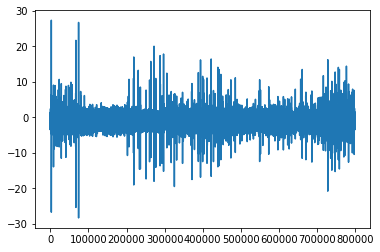

In [243]:

plt.plot(peak_bad_df['270'])



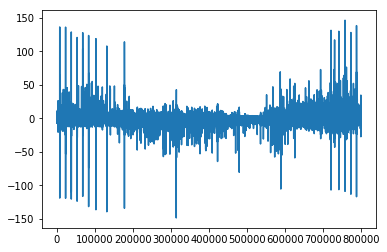

In [244]:
plt.plot(peak_bad_df['279'])

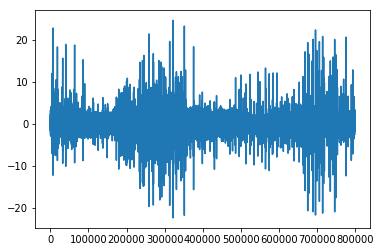

In [245]:
plt.plot(peak_bad_df['287'])

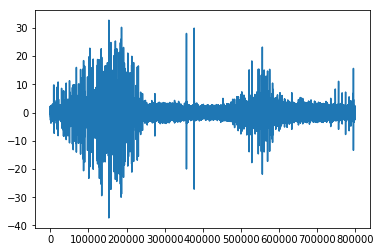

In [246]:
plt.plot(peak_bad_df['410'])

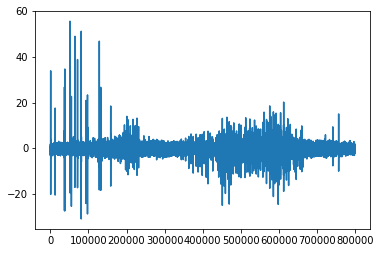

In [247]:
plt.plot(peak_bad_df['433'])

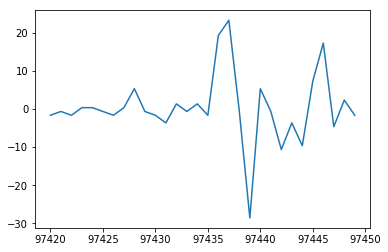

In [260]:
plt.plot(peak_bad_df['433'][97420:97450])

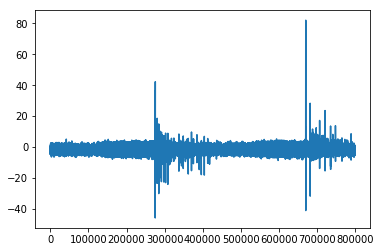

In [248]:
plt.plot(peak_bad_df['436'])

We cant just use an overall positional distribution- as there are clearly shapes to the PD's - they tend to cluster

TODO - group these HF signals into different types (with and withour -4 to 4 v component)

KNN clustering probably going to be way too slow - (try without 4-4?)
try converting to spectrograms then clustering the images

TODO - time shift the HF component - such that distrubution still consistent with overall positional distributions
and combine this with some randome scaling, random intra series shifting

In [ ]:
#TODO drop spikes if >n distance from another spike

In [ ]:
bad_sig_delta_flt = data_as_float(bad_sig_delta_list)

In [98]:
len(bad_sig_delta_flt)

5513107

In [118]:
#take a sample for plotting
n_up_delta=random.sample(bad_sig_delta_flt, int(len(bad_sig_delta_flt)/10))

(array([1.6000e+01, 3.1000e+01, 1.7000e+01, 2.3000e+01, 2.4000e+01,
        3.0000e+01, 3.9000e+01, 1.6800e+02, 1.1800e+02, 1.4900e+02,
        2.0900e+02, 1.8300e+02, 2.7500e+02, 1.4900e+02, 1.1500e+02,
        2.1100e+02, 1.6900e+02, 3.8400e+02, 3.2200e+02, 2.0800e+02,
        2.6400e+02, 2.8800e+02, 3.1500e+02, 3.5700e+02, 2.5100e+02,
        2.1600e+02, 3.2500e+02, 3.2600e+02, 2.1100e+02, 2.7900e+02,
        5.0700e+02, 5.5300e+02, 6.7200e+02, 6.2800e+02, 5.8400e+02,
        8.3200e+02, 9.5000e+02, 9.4400e+02, 7.6000e+02, 9.7700e+02,
        7.6800e+02, 6.0200e+02, 1.0000e+03, 9.0300e+02, 8.4900e+02,
        1.0080e+03, 1.0670e+03, 1.0130e+03, 5.7700e+02, 7.2100e+02,
        9.0000e+02, 8.7000e+02, 8.2300e+02, 1.0580e+03, 1.3370e+03,
        1.4560e+03, 1.1160e+03, 1.2370e+03, 1.3970e+03, 1.3290e+03,
        1.1310e+03, 1.3110e+03, 1.3140e+03, 1.4260e+03, 8.8100e+02,
        9.6400e+02, 1.0850e+03, 1.7510e+03, 1.2150e+03, 1.3220e+03,
        1.8270e+03, 1.5140e+03, 1.5190e+03, 1.80

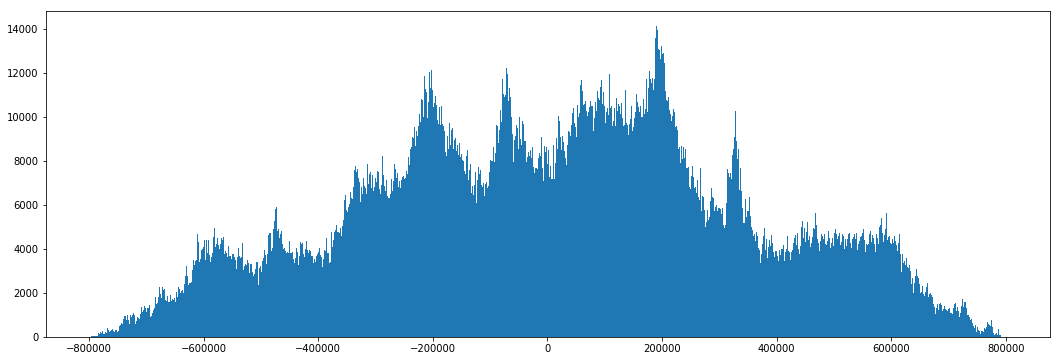

In [111]:
plt.figure(figsize=(18, 6))
plt.hist(n_up_delta, bins=1000)

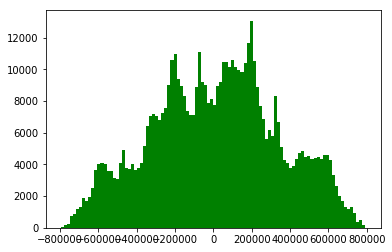

mu: 0.009900990099009903, sigma: 0.005927879663812219


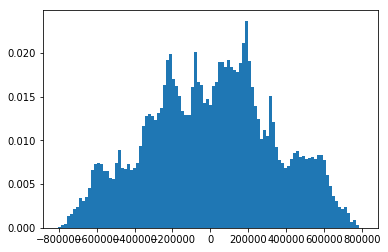

In [135]:
n, bins, patches = plt.hist(n_up_delta, 100, histtype='bar', color='green')
plt.show()
n = n/len(n_up_delta)
n = np.append(n, 0)
mu = np.mean(n)
sigma = np.std(n)
print(f'mu: {mu}, sigma: {sigma}')
plt.bar(bins,n, width=(bins[len(bins)-1]-bins[0])/100)
#y1= (1/(sigma*np.sqrt(2*np.pi))*np.exp(-(bins - mu)**2 /(2*sigma**2)))*.03
#plt.plot(bins, y1, 'r--', linewidth=2)
plt.show()

In [145]:
bins[0], bins[0]-bins[1], bins[2]-bins[3], bins[100], len(bins), len(n), n[0]

(-796219.0,
 -15891.569999999949,
 -15891.569999999949,
 792938.0,
 101,
 101,
 0.00011427327637808129)

In [147]:
prob_bad_df=pd.DataFrame.from_dict({'bin': bins, 'probability': n})

In [148]:
prob_bad_df.head()

,bin,probability
0,-796219.00,0.000114
1,-780327.43,0.000370
2,-764435.86,0.000479
3,-748544.29,0.001322
4,-732652.72,0.001535


In [154]:
import math
log_ampl=[math.log(x) for x in bad_sig_ampl_flt]

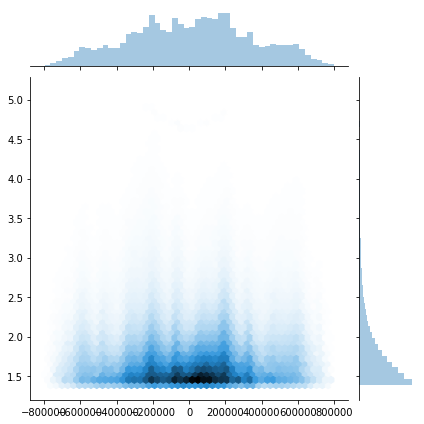

In [155]:
import seaborn as sns
sns.jointplot(x=bad_sig_delta_flt, y=log_ampl, kind='hex')
plt.show()

In [ ]:
#TODO calculateamplitude distribution / probability per bin

In [197]:
bad_sig_df = pd.DataFrame(
    {'delta': bad_sig_delta_flt,
     'ampl': bad_sig_ampl_flt})



In [198]:
bad_sig_df.head()

,delta,ampl
0,-305035.0,9.559936
1,-301673.0,14.972765
2,-301670.0,5.972229
3,-300653.0,5.789551
4,-300650.0,5.789009


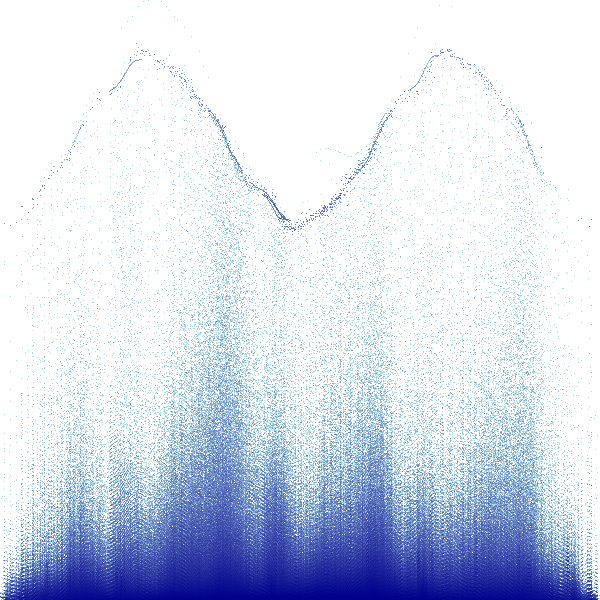

In [200]:
tf.shade(ds.Canvas().points(bad_sig_df,'delta','ampl'))

### Time shifting

Statistical recreation of bad signals will be pretty difficult - while can get overall distance and amplitude distribution and can see clear relationships between PD distance and amplitude wrt the 50Hz phase, as well as this PD's show specific shapes - which are difficult to re-create.

Below we use time-shits with some randomization of amplitudes (of the HF components) for augmentingbad PD examples

In [26]:
bad_sig_deltas = pd.read_csv(f'../input/signal_analysis/bad_signals/sig_deltas.csv', names=['signal_name', 'delta'])

In [27]:
bad_sig_deltas.head()

,signal_name,delta
0,3_delta,"[-305035, -301673, -301670, -300653, -300650, ..."
1,4_delta,"[-569403, -566041, -565020, -549453, -544708, ..."
2,5_delta,"[-39162, -39160, -39157, -35800, -35798, -3579..."
3,201_delta,"[-441225, -441223, -441216, -441214, -441100, ..."
4,202_delta,"[-706095, -706091, -705971, -705961, -696129, ..."


In [43]:
bad_sig_del_d = create_sig_dict(bad_sig_deltas, 'delta')

In [48]:
len(list(bad_sig_del_d.keys())), len(bad_sig_del_d['3'])

(525, 264)

In [50]:
bad_sig_idxs = pd.read_csv(f'../input/signal_analysis/bad_signals/sig_idxs.csv', names=['signal_name', 'idx'])


In [53]:
bad_sig_idxs.head()

,signal_name,idx
0,3,"[2629, 5991, 5994, 7011, 7014, 14232, 14235, 1..."
1,4,"[2632, 5994, 7015, 22582, 27327, 34747, 34748,..."
2,5,"[2630, 2632, 2635, 5992, 5994, 5997, 6047, 604..."
3,201,"[1081, 1083, 1090, 1092, 1206, 1208, 1217, 549..."
4,202,"[1083, 1087, 1207, 1217, 11049, 11054, 11062, ..."


In [61]:
bad_sig_idx_d = create_sig_dict(bad_sig_idxs, 'idx', split_signal_name=False)

In [63]:
bad_sig_ampls = pd.read_csv(f'../input/signal_analysis/bad_signals/sig_ampls.csv', names=['signal_name', 'ampl'])


In [64]:
bad_sig_ampls_d = create_sig_dict(bad_sig_ampls, 'ampl', split_signal_name=True)

In [66]:
bad_lf_min = pd.read_csv(f'../input/signal_analysis/bad_signals/lf_min.csv', names=['signal_name', 'min_idx'], header=None)

In [67]:
bad_lf_min.head()

,signal_name,min_idx
0,3,714929
1,4,177393
2,5,438584
3,201,45363
4,202,305495


In [68]:
bad_lf_max = pd.read_csv(f'../input/signal_analysis/bad_signals/lf_max.csv', names=['signal_name', 'max_idx'], header=None)


In [69]:
bad_lf_max.head()

,signal_name,max_idx
0,3,307664
1,4,572035
2,5,41792
3,201,442306
4,202,707178
